In [1]:
import pandas as pd          
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense

In [2]:
df = pd.concat(map(pd.read_csv, ['tennis_atp/atp_matches_2018.csv','tennis_atp/atp_matches_2019.csv', 'tennis_atp/atp_matches_2020.csv','tennis_atp/atp_matches_2021.csv','tennis_atp/atp_matches_2022.csv','tennis_atp/atp_matches_2023.csv','tennis_atp/atp_matches_2024.csv']))

In [3]:
# Remove identifying data
# Find a way to include tourney_level and score
df = df.drop(columns=['winner_id', 'winner_name', 'winner_ioc', 
                      'loser_id', 'loser_name', 'loser_ioc', 
                      'tourney_id', 'tourney_name', 'tourney_level', 
                      'tourney_date', 'match_num', 'winner_seed', 
                      'winner_entry', 'loser_seed', 'loser_entry','score', 'draw_size', 'best_of', 'round', "w_SvGms", "l_SvGms", "w_bpSaved", "l_bpSaved", "w_bpFaced", "l_bpFaced","minutes"])


In [4]:
# Check for missing values.
print(df.isnull().sum())

# There are zero duplicates no action needed
print(df.duplicated().sum())

# Drop any rows with nulls in them
df = df.dropna()

# Check total number of rows, should be over 15k
row_count = len(df)
print(row_count)

surface                53
winner_hand             0
winner_ht              79
winner_age              3
loser_hand              1
loser_ht              227
loser_age               3
w_ace                 694
w_df                  694
w_svpt                694
w_1stIn               694
w_1stWon              694
w_2ndWon              694
l_ace                 694
l_df                  694
l_svpt                694
l_1stIn               694
l_1stWon              694
l_2ndWon              694
winner_rank            79
winner_rank_points     79
loser_rank            222
loser_rank_points     222
dtype: int64
2
17946


## Convert Categorical Variables to Numerical

In [5]:
winner_encoder = LabelEncoder()
loser_encoder = LabelEncoder()
surface_encoder = LabelEncoder()
round_encoder = LabelEncoder()


df['winner_hand'] = winner_encoder.fit_transform(df['winner_hand'])
df['loser_hand'] = loser_encoder.fit_transform(df['loser_hand'])
df['surface'] = surface_encoder.fit_transform(df['surface'])

In [6]:
# Rename values to not be associated with winner.
df = df.rename(columns={
    'winner_age': 'p1_age',
    'winner_ht': 'p1_ht',
    'winner_hand': 'p1_hand',
    'winner_rank': 'p1_rank',
    'winner_rank_points': 'p1_rank_points',
    'loser_age': 'p2_age',
    'loser_ht': 'p2_ht',
    'loser_hand': 'p2_hand',
    'loser_rank': 'p2_rank',
    'loser_rank_points': 'p2_rank_points',
    
    'w_ace': 'p1_ace',
    'w_df': 'p1_df',
    'w_svpt': 'p1_svpt',
    'w_1stIn': 'p1_1stIn',
    'w_1stWon': 'p1_1stWon',
    'w_2ndWon': 'p1_2ndWon',

    'l_ace': 'p2_ace',
    'l_df': 'p2_df',
    'l_svpt': 'p2_svpt',
    'l_1stIn': 'p2_1stIn',
    'l_1stWon': 'p2_1stWon',
    'l_2ndWon': 'p2_2ndWon',
})

swap_mask = np.random.rand(len(df)) > 0.5

swap_cols = [
    'age', 'ht', 'hand', 'rank', 'rank_points',
    'ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon'
]

for col in swap_cols:
    temp = df.loc[swap_mask, f'p1_{col}'].copy()
    df.loc[swap_mask, f'p1_{col}'] = df.loc[swap_mask, f'p2_{col}']
    df.loc[swap_mask, f'p2_{col}'] = temp

df['winner'] = np.where(swap_mask, 1, 0)

print(df['winner'].value_counts())

winner
1    9011
0    8935
Name: count, dtype: int64


In [7]:
# Display the first and last few rows of the dataset.
display(df.head())
display(df.tail())

# Display the info of the dataset.
display(df.info())

# Display summary statistics of the dataset.
display(df.describe())

,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,p1_ace,p1_df,p1_svpt,...,p2_df,p2_svpt,p2_1stIn,p2_1stWon,p2_2ndWon,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
0,2,1,188.0,30.6,1,185.0,25.6,10.0,3.0,80.0,...,2.0,82.0,49.0,39.0,20.0,52.0,909.0,47.0,1010.0,1
1,2,1,188.0,21.2,1,183.0,23.7,5.0,3.0,58.0,...,5.0,62.0,41.0,25.0,7.0,54.0,890.0,94.0,593.0,0
2,2,1,175.0,25.6,1,185.0,31.3,8.0,6.0,120.0,...,0.0,94.0,66.0,48.0,12.0,30.0,1391.0,63.0,809.0,1
3,2,1,188.0,28.0,1,183.0,18.8,6.0,2.0,80.0,...,3.0,66.0,37.0,32.0,17.0,44.0,1055.0,208.0,245.0,1
4,2,0,193.0,27.2,1,188.0,19.9,4.0,0.0,45.0,...,4.0,55.0,38.0,32.0,11.0,68.0,755.0,175.0,299.0,1


,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,p1_ace,p1_df,p1_svpt,...,p2_df,p2_svpt,p2_1stIn,p2_1stWon,p2_2ndWon,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
3064,2,1,175.0,25.0,1,183.0,28.2,1.0,2.0,52.0,...,1.0,50.0,35.0,19.0,5.0,569.0,64.0,819.0,24.0,0
3066,2,1,188.0,28.8,1,178.0,31.0,3.0,2.0,49.0,...,2.0,56.0,35.0,30.0,11.0,900.0,18.0,279.0,205.0,1
3068,0,0,185.0,23.9,1,188.0,21.8,1.0,2.0,74.0,...,5.0,92.0,52.0,24.0,18.0,616.0,55.0,740.0,34.0,0
3070,0,0,185.0,23.9,1,175.0,34.2,1.0,1.0,82.0,...,1.0,50.0,30.0,19.0,14.0,616.0,55.0,136.0,489.0,1
3074,2,1,185.0,27.3,1,175.0,26.9,5.0,3.0,86.0,...,1.0,84.0,61.0,41.0,13.0,416.0,109.0,554.0,67.0,1


<class 'pandas.core.frame.DataFrame'>
Index: 17946 entries, 0 to 3074
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   surface         17946 non-null  int64  
 1   p1_hand         17946 non-null  int64  
 2   p1_ht           17946 non-null  float64
 3   p1_age          17946 non-null  float64
 4   p2_hand         17946 non-null  int64  
 5   p2_ht           17946 non-null  float64
 6   p2_age          17946 non-null  float64
 7   p1_ace          17946 non-null  float64
 8   p1_df           17946 non-null  float64
 9   p1_svpt         17946 non-null  float64
 10  p1_1stIn        17946 non-null  float64
 11  p1_1stWon       17946 non-null  float64
 12  p1_2ndWon       17946 non-null  float64
 13  p2_ace          17946 non-null  float64
 14  p2_df           17946 non-null  float64
 15  p2_svpt         17946 non-null  float64
 16  p2_1stIn        17946 non-null  float64
 17  p2_1stWon       17946 non-null  float

None

,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,p1_ace,p1_df,p1_svpt,...,p2_df,p2_svpt,p2_1stIn,p2_1stWon,p2_2ndWon,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
count,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,...,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000
mean,1.285468,0.865095,187.170066,27.124535,0.857573,187.289647,27.137167,6.293770,2.932743,81.128664,...,2.933913,80.964560,50.428675,36.103700,15.475092,79.064694,1530.550429,79.561908,1542.902374,0.502117
std,0.901457,0.341631,7.189746,4.560654,0.349498,6.981464,4.582772,5.392611,2.434175,29.251292,...,2.453055,29.180213,19.159222,14.210902,6.891466,107.007024,1718.922947,108.627246,1748.885633,0.500009
min,0.000000,0.000000,15.000000,16.500000,0.000000,71.000000,16.400000,0.000000,0.000000,3.000000,...,0.000000,5.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,1.000000,183.000000,23.600000,1.000000,183.000000,23.600000,2.000000,1.000000,59.000000,...,1.000000,59.000000,36.000000,26.000000,11.000000,26.000000,647.000000,25.000000,643.000000,0.000000
50%,2.000000,1.000000,188.000000,26.800000,1.000000,188.000000,26.700000,5.000000,2.000000,76.000000,...,2.000000,76.000000,47.000000,34.000000,14.000000,55.000000,951.000000,55.000000,950.000000,1.000000
75%,2.000000,1.000000,193.000000,30.200000,1.000000,193.000000,30.300000,9.000000,4.000000,97.000000,...,4.000000,97.000000,61.000000,44.000000,19.000000,94.000000,1625.000000,94.000000,1665.000000,1.000000
max,2.000000,1.000000,211.000000,42.300000,1.000000,211.000000,42.500000,67.000000,26.000000,278.000000,...,26.000000,291.000000,218.000000,171.000000,56.000000,1921.000000,12415.000000,2146.000000,12415.000000,1.000000


In [8]:
# Check for missing values.
print(df.isnull().sum())

# There are zero duplicates
print(df.duplicated().sum())

surface           0
p1_hand           0
p1_ht             0
p1_age            0
p2_hand           0
p2_ht             0
p2_age            0
p1_ace            0
p1_df             0
p1_svpt           0
p1_1stIn          0
p1_1stWon         0
p1_2ndWon         0
p2_ace            0
p2_df             0
p2_svpt           0
p2_1stIn          0
p2_1stWon         0
p2_2ndWon         0
p1_rank           0
p1_rank_points    0
p2_rank           0
p2_rank_points    0
winner            0
dtype: int64
0


## Drop Nulls

In [9]:
# Drop any rows with nulls in them
df = df.dropna()

# Check 
row_count = len(df)
print(row_count)

17946


## Scale Features

In [10]:
scaler = StandardScaler()
y = df['winner'].values

X = df.drop(columns=['winner'])
scaler = StandardScaler()
X = scaler.fit_transform(X)

display(y)
display(X)

array([1, 0, 1, ..., 0, 1, 1])

array([[ 0.79266389,  0.39489496,  0.11543626, ..., -0.36160303,
        -0.29976655, -0.30471817],
       [ 0.79266389,  0.39489496,  0.11543626, ..., -0.37265677,
         0.1329178 , -0.54316236],
       [ 0.79266389,  0.39489496, -1.69274477, ..., -0.08118707,
        -0.15246975, -0.4196517 ],
       ...,
       [-1.42602849, -2.53231898, -0.30183629, ..., -0.85843961,
         6.08002614, -0.86280337],
       [-1.42602849, -2.53231898, -0.30183629, ..., -0.85843961,
         0.5195719 , -0.60263045],
       [ 0.79266389,  0.39489496, -0.30183629, ..., -0.82702371,
         4.36770083, -0.84393368]])

## Split data into testing and training

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
display(y_train)

array([0, 0, 1, ..., 0, 0, 0])

## Visualizing the results

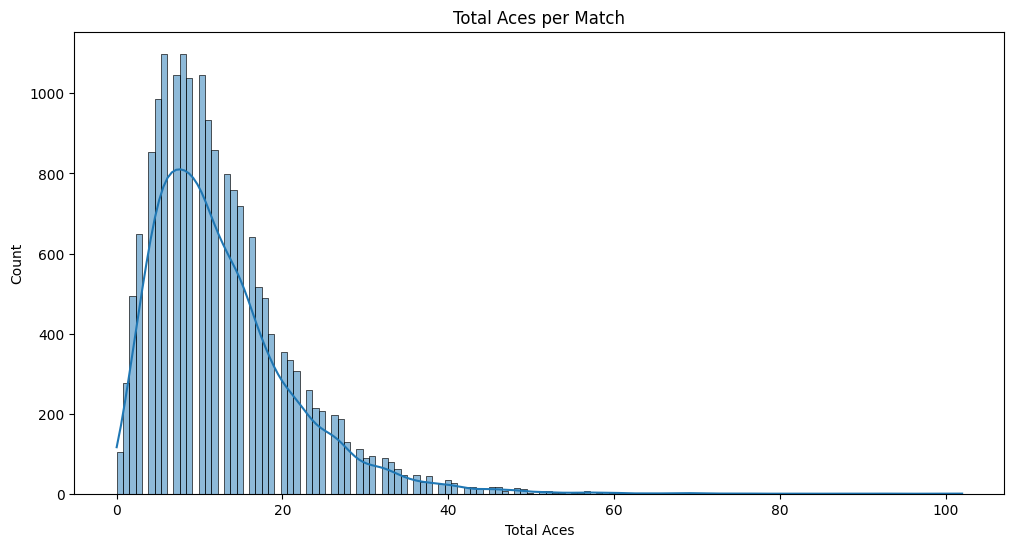

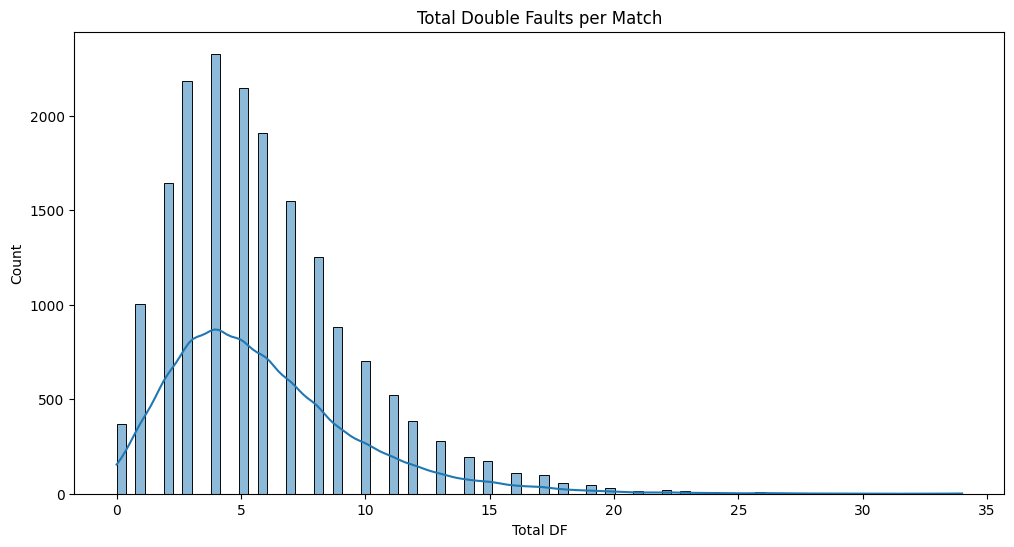

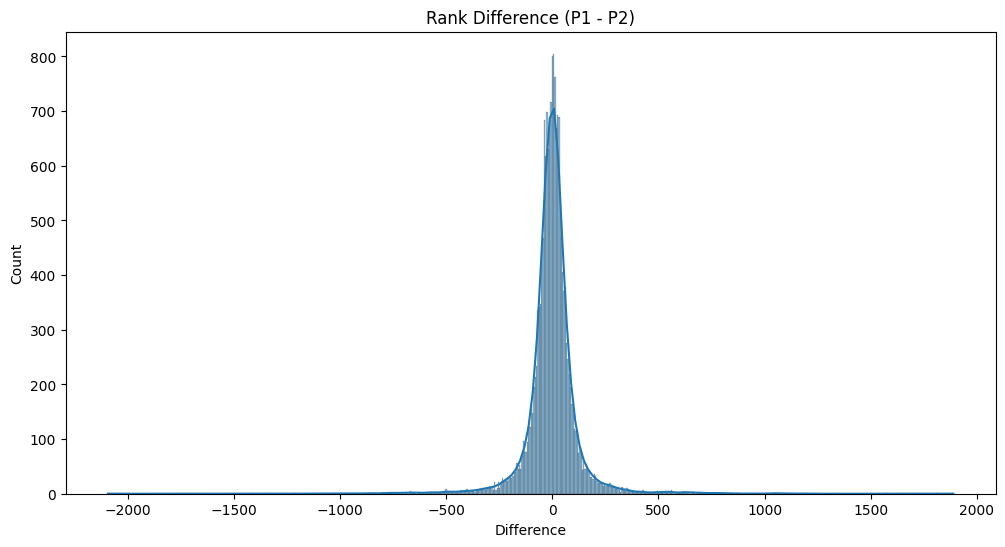

In [12]:
#visualizing the dataset under 4 main categories covering 20 plots
#match overview, serving stats, player attributes, and outcome insights
#these 4 are the general basis but the plots after the first 20 cover more stuff and other variables too
#----------match overview----------
plt.rcParams["figure.figsize"] = (12, 6)

#plot 2: Total Aces Per Match
#displays the service dominance!!!
#a high total may suggest an aggressive play style due to high aces
sns.histplot(df['p1_ace'] + df['p2_ace'], kde=True)
plt.title("Total Aces per Match")
plt.xlabel("Total Aces")
plt.show()

#plot 3: Double Faults Per Match
#reveals how often that the players lose points because of their poor serves
#these double faults can correlate with nerves / poor second serve
sns.histplot(df['p1_df'] + df['p2_df'], kde=True)
plt.title("Total Double Faults per Match")
plt.xlabel("Total DF")
plt.show()

#plot 4: Rank Difference
#this rank difference shows how big of a MISMATCH there is
#a large positive or negative can predict ONE-SIDED matches
df['rank_diff'] = df['p1_rank'] - df['p2_rank']
sns.histplot(df['rank_diff'], kde=True)
plt.title("Rank Difference (P1 - P2)")
plt.xlabel("Difference")
plt.show()

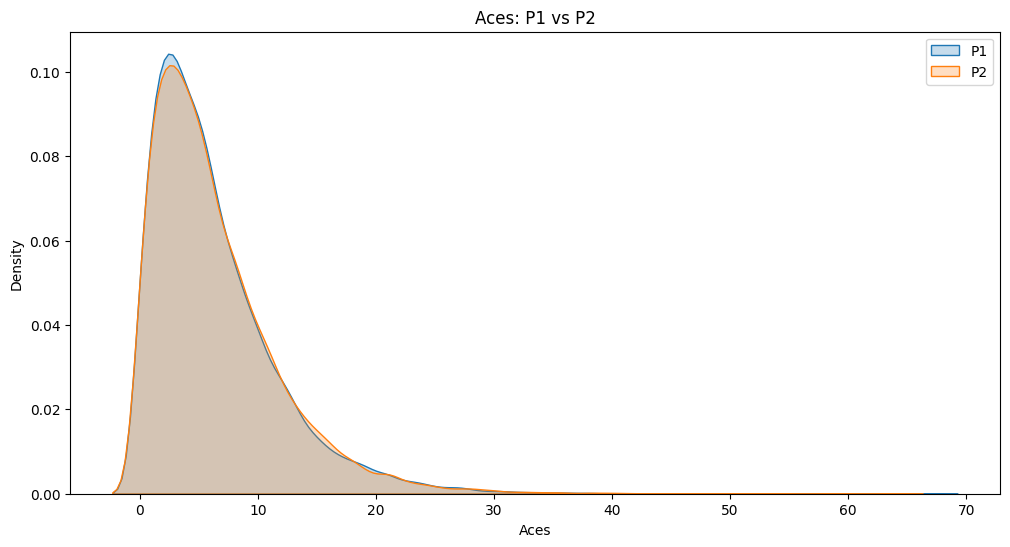

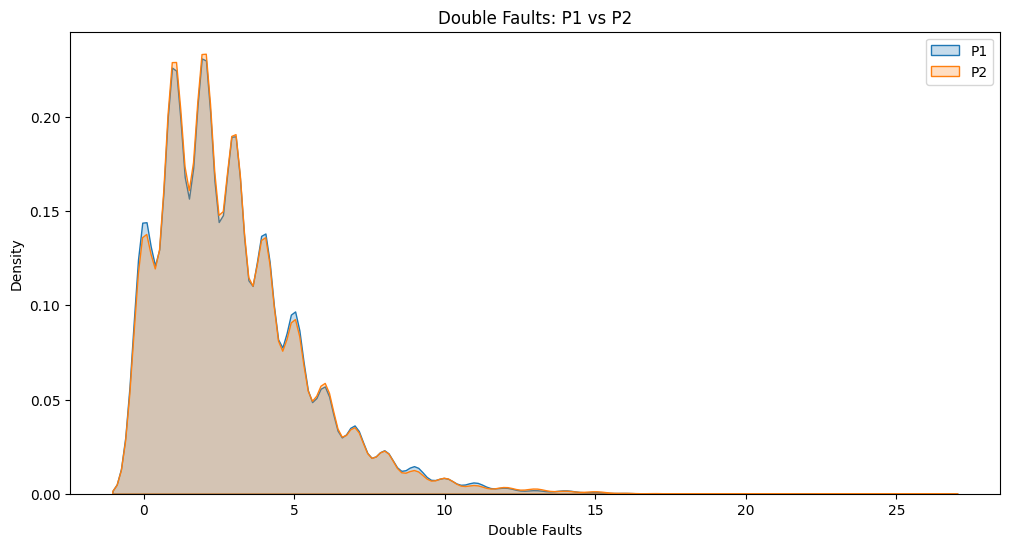

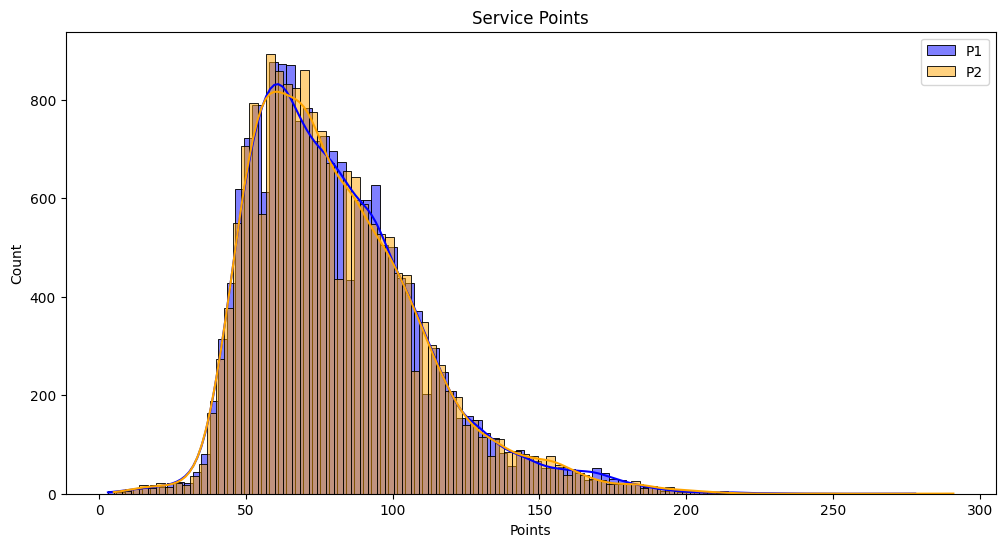

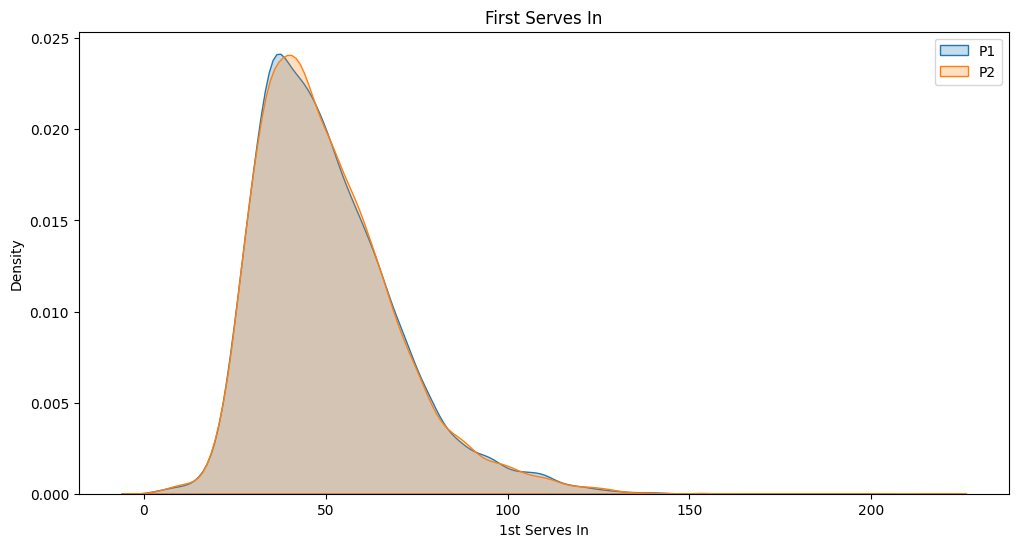

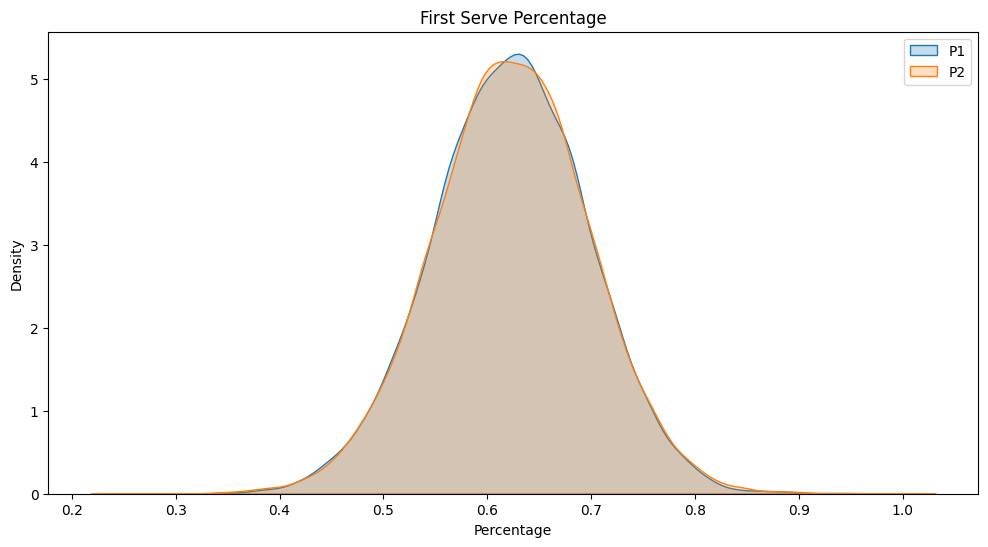

In [13]:
#----------serving stats----------
#plot 5: aces: P1 vs P2
#reveals if either side is consistent or makes more unreturnable (ace) serves
sns.kdeplot(df['p1_ace'], label='P1', fill=True)
sns.kdeplot(df['p2_ace'], label='P2', fill=True)
plt.title("Aces: P1 vs P2")
plt.xlabel("Aces")
plt.legend()
plt.show()

#plot 6:Double Faults: P1 vs P2
#this plot highlights error rates for players
sns.kdeplot(df['p1_df'], label='P1', fill=True)
sns.kdeplot(df['p2_df'], label='P2', fill=True)
plt.title("Double Faults: P1 vs P2")
plt.xlabel("Double Faults")
plt.legend()
plt.show()

#plot 7: Service Points: P1 vs P2
#total serve points per player
sns.histplot(df['p1_svpt'], color="blue", label="P1", kde=True)
sns.histplot(df['p2_svpt'], color="orange", label="P2", kde=True)
plt.title("Service Points")
plt.xlabel("Points")
plt.legend()
plt.show()

#Plot 8: First Serves In: P1 vs P2
#the raw first servce counts
#the higher numbers indicate consistency or even longer matches
sns.kdeplot(df['p1_1stIn'], label='P1', fill=True)
sns.kdeplot(df['p2_1stIn'], label='P2', fill=True)
plt.title("First Serves In")
plt.xlabel("1st Serves In")
plt.legend()
plt.show()

#plot 9: First Serve %: P1 vs P2
#serve reliability
#a higher first serve % generally leads to a better win probability
sns.kdeplot(df['p1_1stIn'] / df['p1_svpt'], label='P1', fill=True)
sns.kdeplot(df['p2_1stIn'] / df['p2_svpt'], label='P2', fill=True)
plt.title("First Serve Percentage")
plt.xlabel("Percentage")
plt.legend()
plt.show()

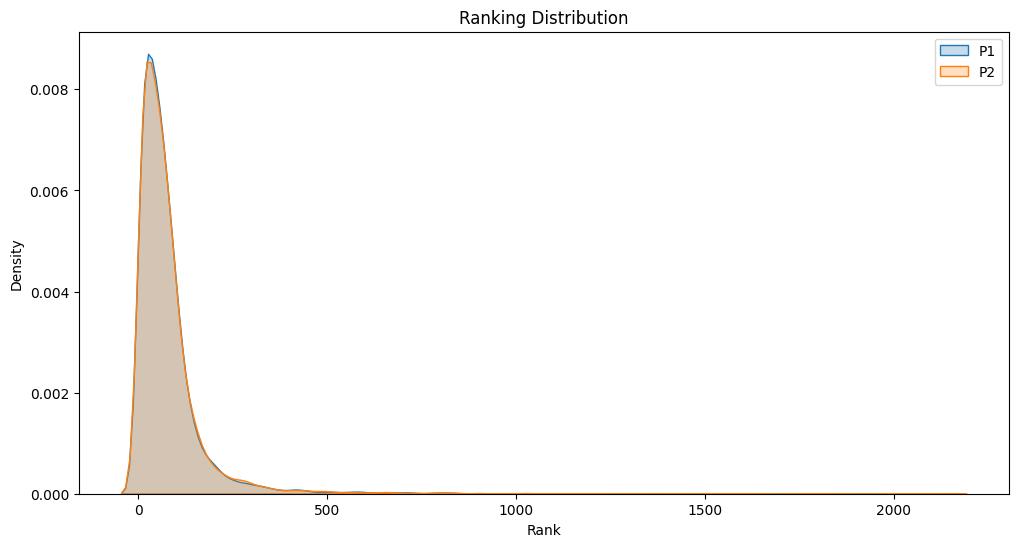

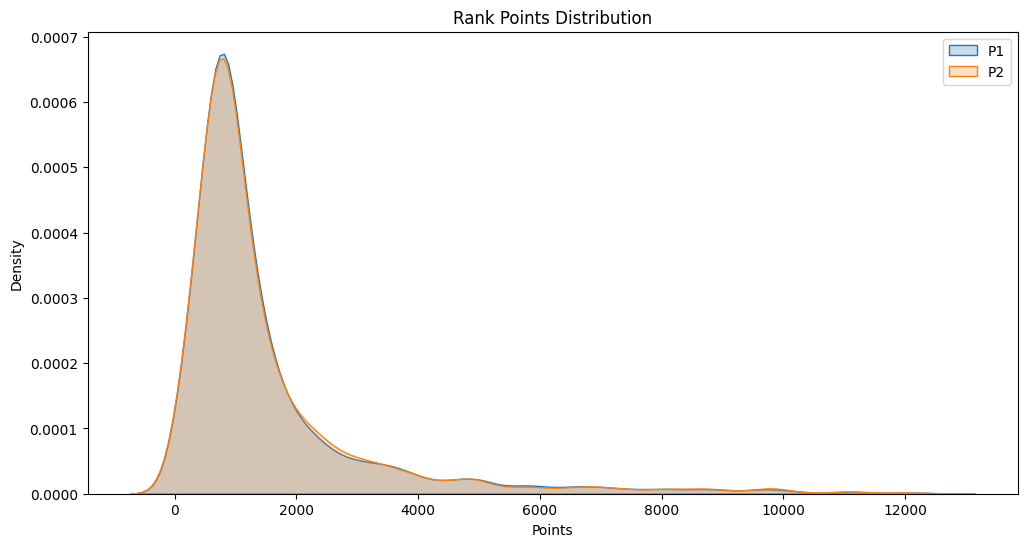

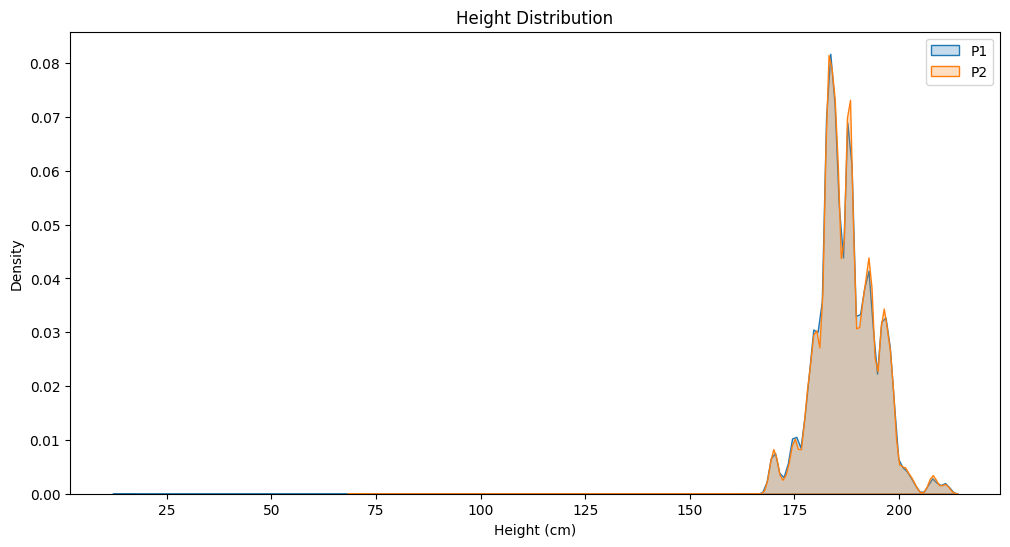

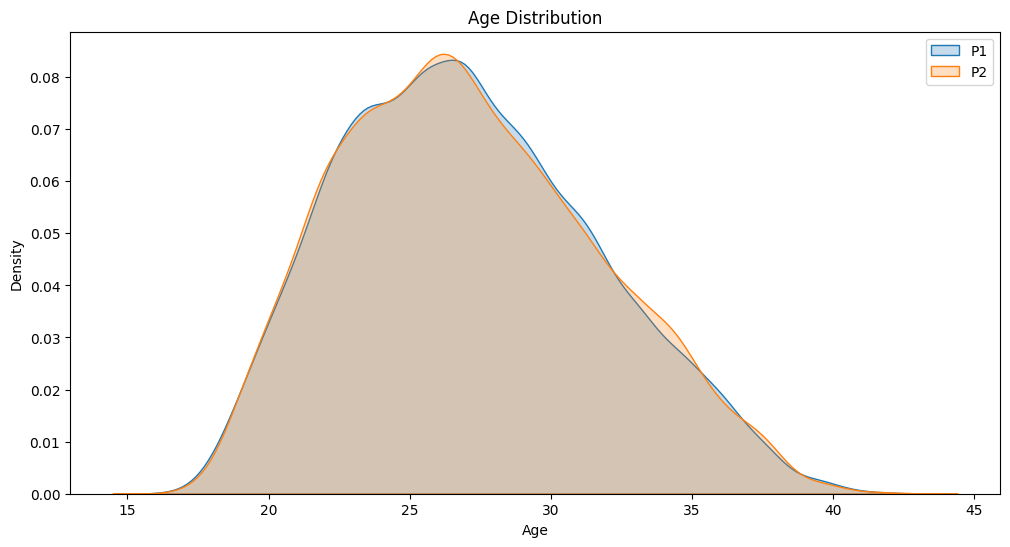

In [14]:
#----------player attributes---------
#plot 10: Ranking: P1 vs P2
#overall player levels
#the concentrated ranges show that most players are in the top 200
sns.kdeplot(df['p1_rank'], label='P1', fill=True)
sns.kdeplot(df['p2_rank'], label='P2', fill=True)
plt.title("Ranking Distribution")
plt.xlabel("Rank")
plt.legend()
plt.show()

#plot 11: Rank Points: P1 vs P2
#shows performance consistency across the season
sns.kdeplot(df['p1_rank_points'], label='P1', fill=True)
sns.kdeplot(df['p2_rank_points'], label='P2', fill=True)
plt.title("Rank Points Distribution")
plt.xlabel("Points")
plt.legend()
plt.show()

#plot 12: Height: P1 vs P2
#does height affect serve, reach, or even court advantage??
sns.kdeplot(df['p1_ht'], label='P1', fill=True)
sns.kdeplot(df['p2_ht'], label='P2', fill=True)
plt.title("Height Distribution")
plt.xlabel("Height (cm)")
plt.legend()
plt.show()

#plot 13: Age: P1 vs P2
#Age. younger players show stamina while the older may show experience
sns.kdeplot(df['p1_age'], label='P1', fill=True)
sns.kdeplot(df['p2_age'], label='P2', fill=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.legend()
plt.show()

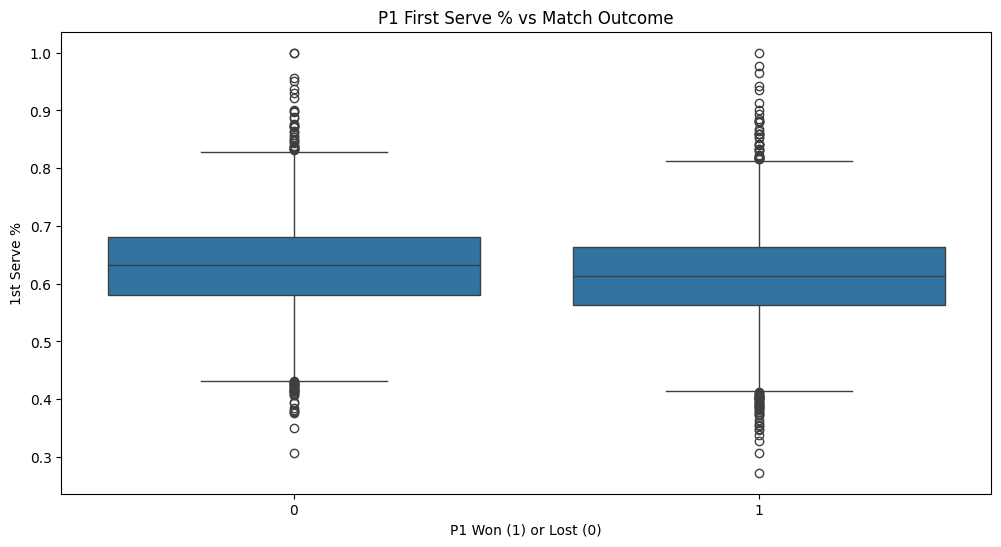

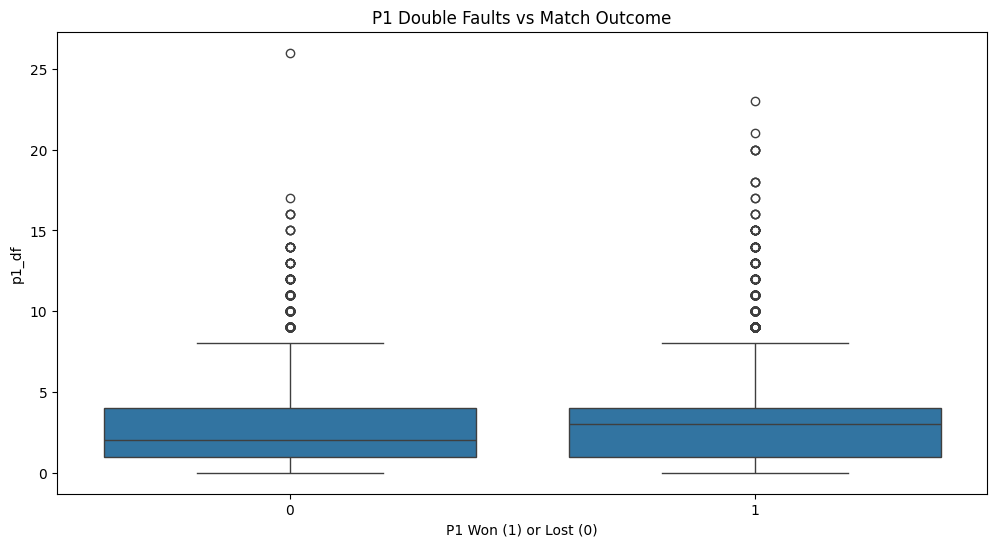

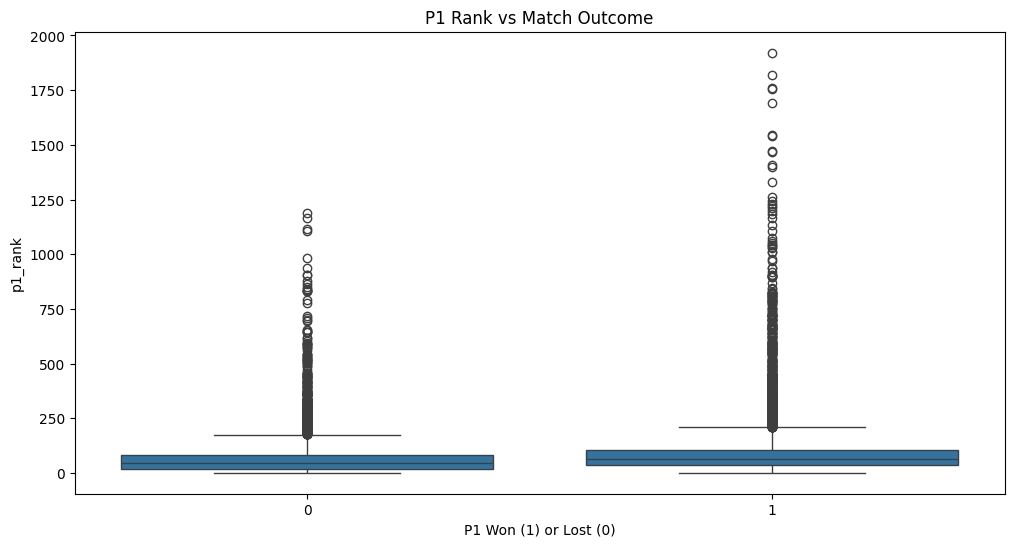

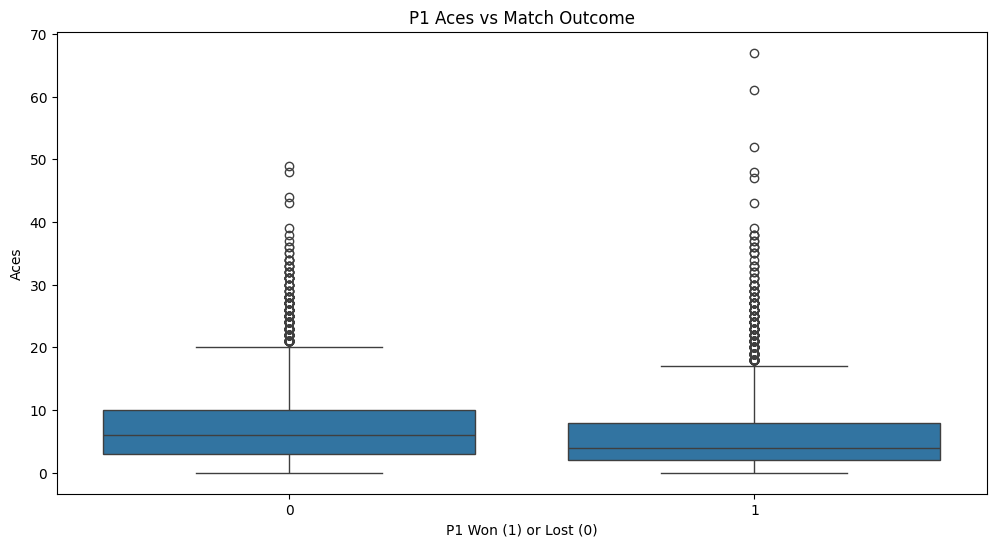

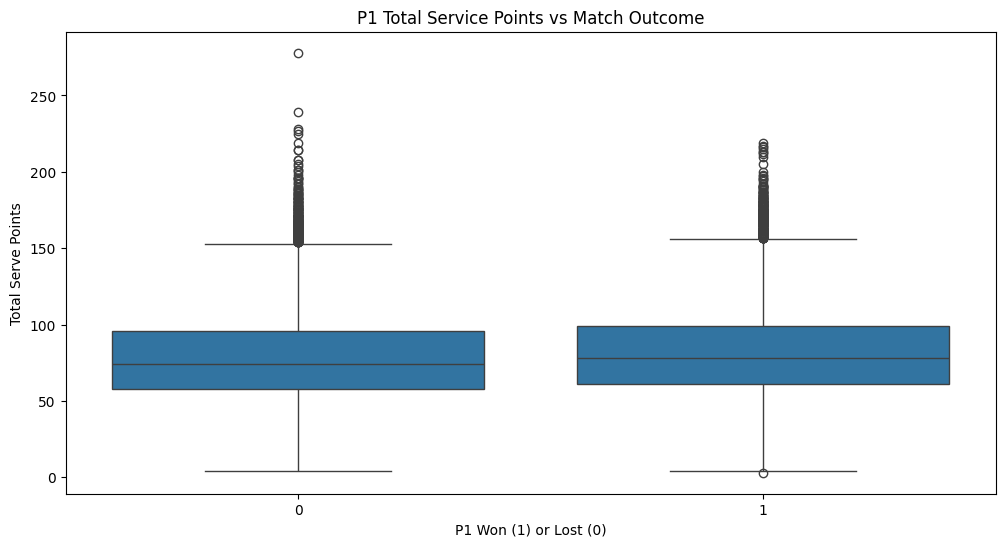

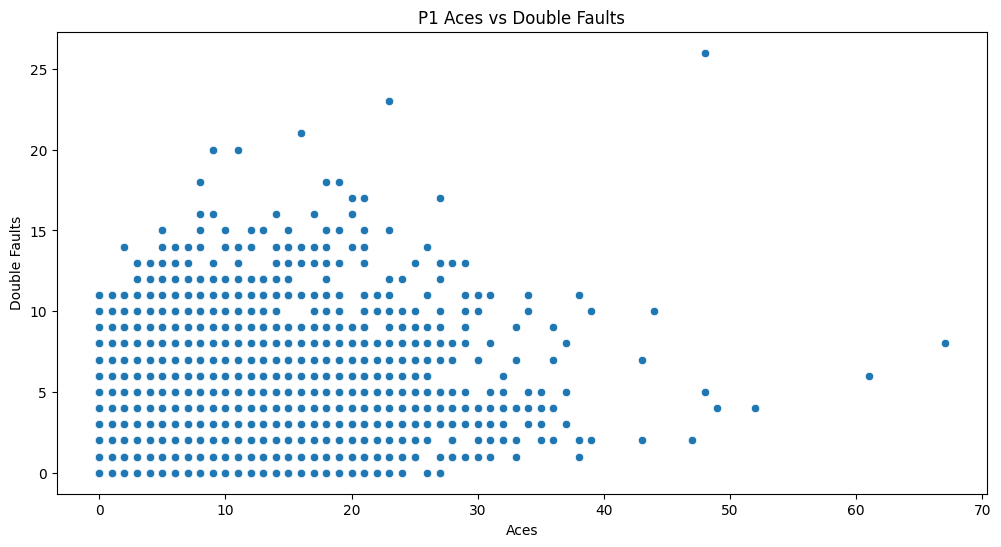

In [15]:
#----------outcomine insights----------
#plot 14: First Serve % vs Win
#a higher first serve % often leads to wins where as a low % can result in more second serve pressure
sns.boxplot(x='winner', y=df['p1_1stIn'] / df['p1_svpt'], data=df)
plt.title("P1 First Serve % vs Match Outcome")
plt.xlabel("P1 Won (1) or Lost (0)")
plt.ylabel("1st Serve %")
plt.show()

#plot 15: Double Faults vs Win
#a higher DF count correlates with losses, ESPECIALLY in close matches
sns.boxplot(x='winner', y='p1_df', data=df)
plt.title("P1 Double Faults vs Match Outcome")
plt.xlabel("P1 Won (1) or Lost (0)")
plt.show()

#plot 16: Rank vs Win
#winners are often in the higher ranks but this shows if there are the UNDERDOGS 
sns.boxplot(x='winner', y='p1_rank', data=df)
plt.title("P1 Rank vs Match Outcome")
plt.xlabel("P1 Won (1) or Lost (0)")
plt.show()

#plot 17: Aces vs Win (P1)
#aces dont GUARANTEE a win but aces are generally corresponded to wins
sns.boxplot(x='winner', y='p1_ace', data=df)
plt.title("P1 Aces vs Match Outcome")
plt.xlabel("P1 Won (1) or Lost (0)")
plt.ylabel("Aces")
plt.show()

#plot 18: Total Service Points vs Win (P1)
#how total points relate to the match outcome
sns.boxplot(x='winner', y='p1_svpt', data=df)
plt.title("P1 Total Service Points vs Match Outcome")
plt.xlabel("P1 Won (1) or Lost (0)")
plt.ylabel("Total Serve Points")
plt.show()

#plot 19: Aces vs Double Faults (P1)
#shows serve styles
#whether they are aggressive (high ace and high df)
#passive (low df, low ace)
sns.scatterplot(x='p1_ace', y='p1_df', data=df)
plt.title("P1 Aces vs Double Faults")
plt.xlabel("Aces")
plt.ylabel("Double Faults")
plt.show()


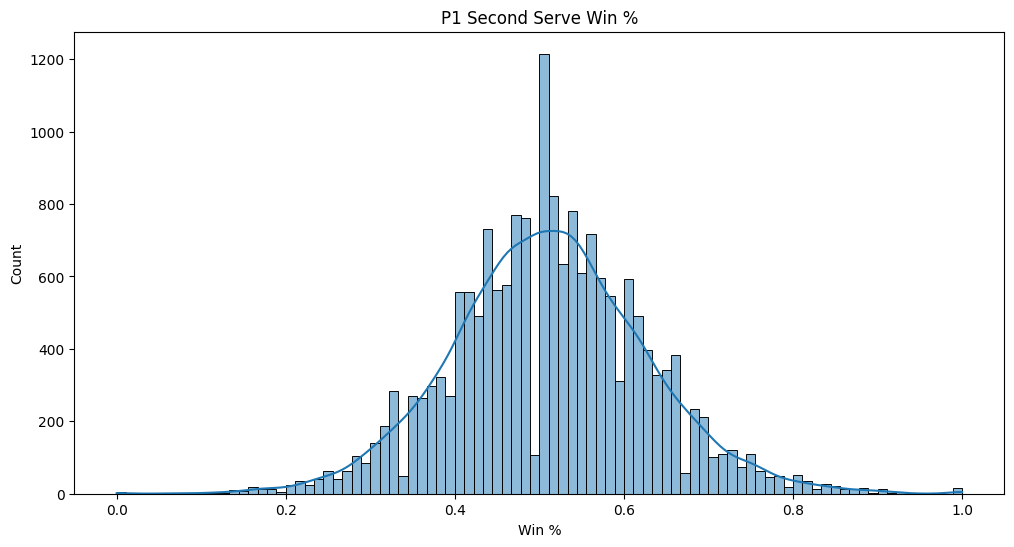

In [16]:
#----------second serve stats----------
#plot 24: Second Serve Win %
df['p1_2ndPct'] = df['p1_2ndWon'] / (df['p1_svpt'] - df['p1_1stIn'])
sns.histplot(df['p1_2ndPct'], kde=True)
plt.title("P1 Second Serve Win %")
plt.xlabel("Win %")
plt.show()

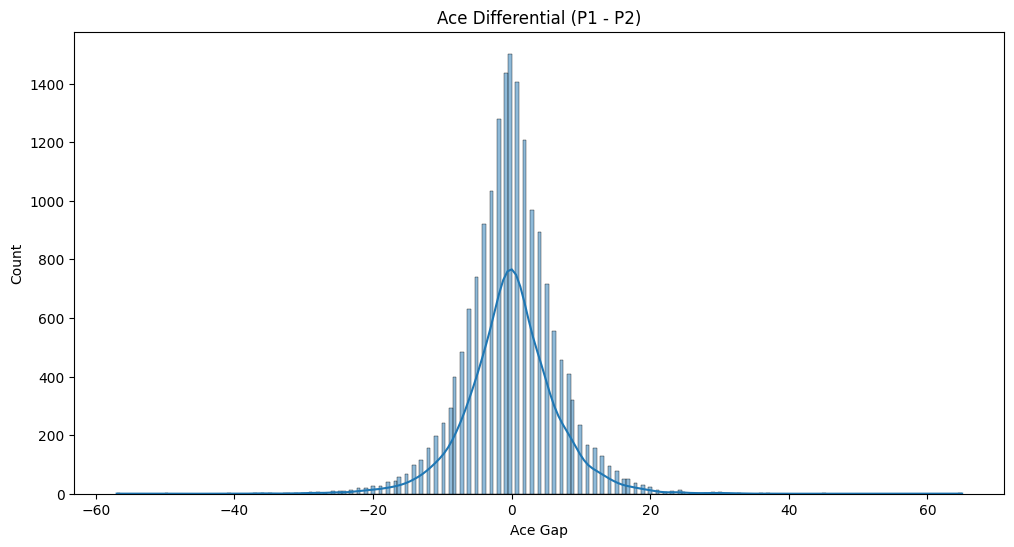

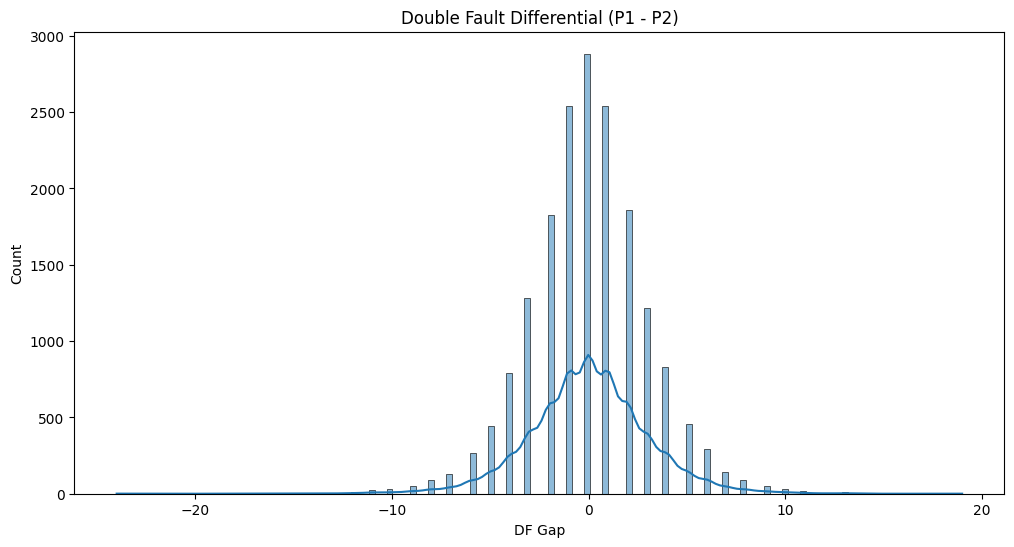

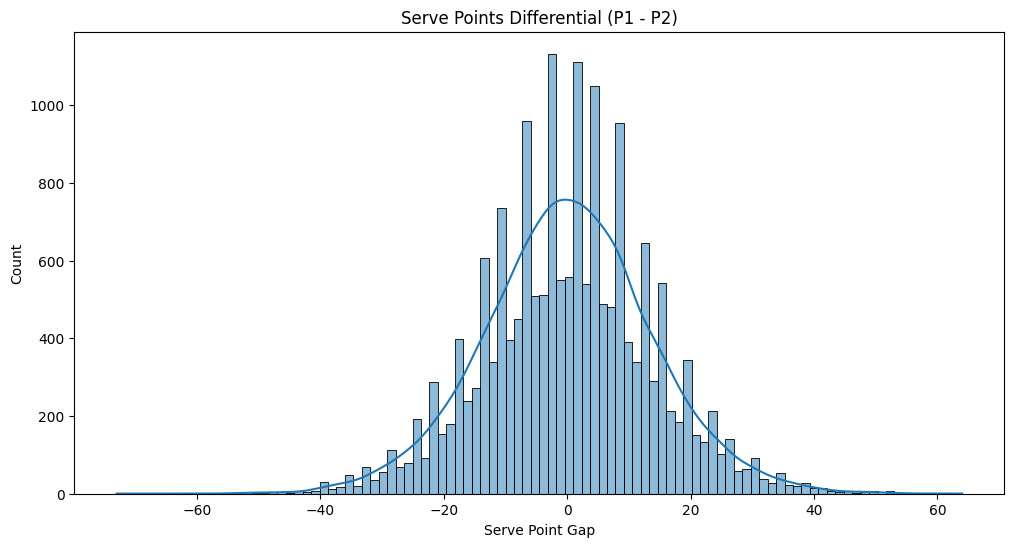

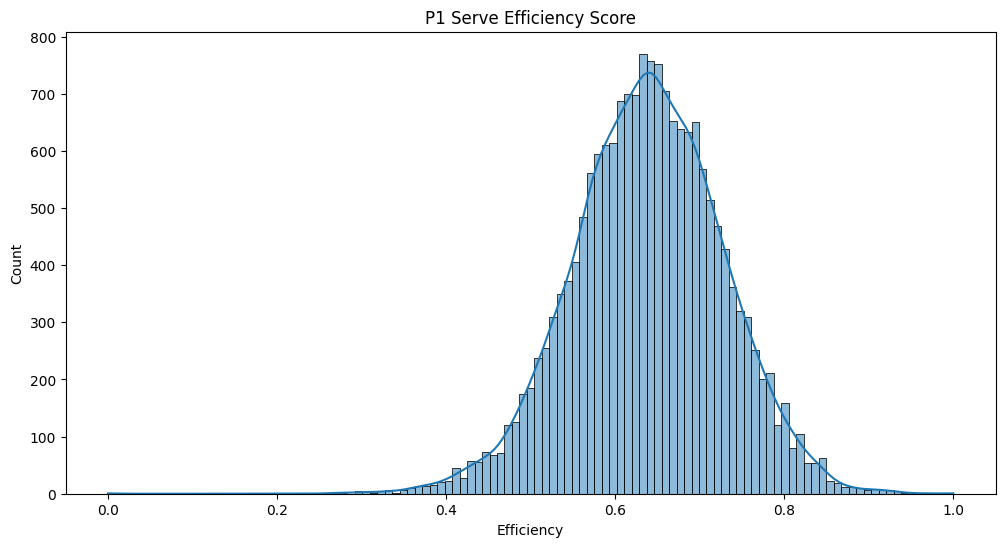

In [17]:
#----------HEAD-TO-HEAD----------
#plot 25: Ace Differential
df['ace_gap'] = df['p1_ace'] - df['p2_ace']
sns.histplot(df['ace_gap'], kde=True)
plt.title("Ace Differential (P1 - P2)")
plt.xlabel("Ace Gap")
plt.show()

#plot 26: Double Fault Differential 
df['df_gap'] = df['p1_df'] - df['p2_df']
sns.histplot(df['df_gap'], kde=True)
plt.title("Double Fault Differential (P1 - P2)")
plt.xlabel("DF Gap")
plt.show()

#plot 27: Serve Points Differential
df['svpt_gap'] = df['p1_svpt'] - df['p2_svpt']
sns.histplot(df['svpt_gap'], kde=True)
plt.title("Serve Points Differential (P1 - P2)")
plt.xlabel("Serve Point Gap")
plt.show()

#plot 28: Serve Efficiency Score (P1)
df['p1_efficiency'] = (df['p1_1stWon'] + df['p1_2ndWon']) / df['p1_svpt']
sns.histplot(df['p1_efficiency'], kde=True)
plt.title("P1 Serve Efficiency Score")
plt.xlabel("Efficiency")
plt.show()

## Reusable functions

In [18]:
# Create a global list to collect model results
model_results = []

def evaluate_model(y_pred_test, y_pred_train, model_name):
    # Calculate test metrics
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test, average='binary')
    recall_test = recall_score(y_test, y_pred_test, average='binary')
    f1_test = f1_score(y_test, y_pred_test, average='binary')

    # Calculate train metrics
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train, average='binary')
    recall_train = recall_score(y_train, y_pred_train, average='binary')
    f1_train = f1_score(y_train, y_pred_train, average='binary')

    # Print the metrics
    print("=== Test Metrics ===")
    print(f"Accuracy: {accuracy_test}")
    print(f"Precision: {precision_test}")
    print(f"Recall: {recall_test}")
    print(f"F1 Score: {f1_test}")

    print("\n=== Training Metrics ===")
    print(f"Accuracy: {accuracy_train}")
    print(f"Precision: {precision_train}")
    print(f"Recall: {recall_train}")
    print(f"F1 Score: {f1_train}")

    print("\nX_train shape:", X_train.shape)

    # Confusion matrix for test data
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix (Test Data) - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Add results to the model_results table
    model_results.append({
        "Model": model_name,
        "Train Accuracy": accuracy_train,
        "Train Precision": precision_train,
        "Train Recall": recall_train,
        "Train F1": f1_train,
        "Test Accuracy": accuracy_test,
        "Test Precision": precision_test,
        "Test Recall": recall_test,
        "Test F1": f1_test
    })

In [19]:
from sklearn.feature_selection import RFE

def iterative_feature_elimination(clf, X_train, y_train, X_test, y_test, feature_names=None, target_name='winner'):    
    # Compute baseline F1 score using all features
    baseline_f1 = f1_score(y_test, clf.predict(X_test))
    print(f"Baseline F1: {baseline_f1:.4f}")
    
    # Get the actual number of features from the data
    num_features = X_train.shape[1]
    
    # Handle default feature names
    if feature_names is None:
        try:
            feature_names = X_train.columns.tolist()
        except AttributeError:
            feature_names = [f"f{i}" for i in range(num_features)]
    
    # Ensure feature_names matches the actual data dimension
    if len(feature_names) != num_features:
        feature_names = feature_names[:num_features] if len(feature_names) > num_features else feature_names + [f"f{i}" for i in range(len(feature_names), num_features)]
    
    # Initial setup
    current_X_train = X_train.copy()
    current_X_test = X_test.copy()
    features = feature_names.copy()
    removed_features = []
    
    print(f"Starting with {len(features)} features")
    
    while len(features) > 1:
        # Sanity check to make sure we're not trying to select more features than we have
        n_features_to_select = len(features) - 1
        
        # Check if we have the correct number of features
        actual_features = current_X_train.shape[1]
        if actual_features != len(features):
            print(f"Error: Feature count mismatch. Have {actual_features} features in data but {len(features)} in feature list.")
            print("Synchronizing feature list with data dimensions")
            features = features[:actual_features]
            n_features_to_select = len(features) - 1
        
        print(f"Selecting {n_features_to_select} features from {len(features)} current features")
        
        selector = RFE(estimator=clf, n_features_to_select=n_features_to_select)
        selector.fit(current_X_train, y_train)
        y_pred = selector.predict(current_X_test)
        new_f1 = f1_score(y_test, y_pred)
        
        mask = ~selector.support_
        if not np.any(mask):
            print("No features were dropped. Stopping.")
            break
            
        dropped_idx = np.where(mask)[0][0]
        dropped_feat = features[dropped_idx]
        
        if new_f1 < baseline_f1:
            removed_features.append(dropped_feat)
            print(f"→ Stopping: dropping '{dropped_feat}' drops F1 from {baseline_f1:.4f} to {new_f1:.4f}")
            break
            
        removed_features.append(dropped_feat)
        print(f"Removed '{dropped_feat}' → new F1 = {new_f1:.4f}")
        
        # Update feature list
        features.pop(dropped_idx)
        
        # Update data matrices
        if isinstance(current_X_train, pd.DataFrame):
            current_X_train = current_X_train.iloc[:, selector.support_]
            current_X_test = current_X_test.iloc[:, selector.support_]
        else:
            current_X_train = current_X_train[:, selector.support_]
            current_X_test = current_X_test[:, selector.support_]
    
    print(f"\nTotal removed: {len(removed_features)} features")
    print("Features removed (in order):")
    for feat in removed_features:
        print(f" - {feat}")
    
    return removed_features, features, new_f1

## Neural Network

In [20]:
# Shallow model for binary classification
shallow_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')  # Single output node with sigmoid for binary classification
])

shallow_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

shallow_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

shallow_test_loss, shallow_test_acc = shallow_model.evaluate(X_test, y_test, verbose=0)

y_pred = (shallow_model.predict(X_test) > 0.5).astype(int).flatten()

shallow_test_precision = precision_score(y_test, y_pred)
shallow_test_recall = recall_score(y_test, y_pred)
shallow_test_f1 = f1_score(y_test, y_pred)

print(f'Shallow Network Test Accuracy: {shallow_test_acc:.4f}')
print(f'Precision: {shallow_test_precision:.4f}')
print(f'Recall: {shallow_test_recall:.4f}')
print(f'F1 Score: {shallow_test_f1:.4f}')

C:\Users\mathe\anaconda3\envs\machineLearning\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7146 - loss: 0.5658 - val_accuracy: 0.8451 - val_loss: 0.3714
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8729 - loss: 0.3296 - val_accuracy: 0.9136 - val_loss: 0.2450
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9238 - loss: 0.2183 - val_accuracy: 0.9335 - val_loss: 0.1840
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9422 - loss: 0.1649 - val_accuracy: 0.9384 - val_loss: 0.1592
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9478 - loss: 0.1434 - val_accuracy: 0.9394 - val_loss: 0.1514
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9537 - loss: 0.1301 - val_accuracy: 0.9425 - val_loss: 0.1453
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9522 - loss: 0.1271 - val_accuracy: 0.9394 - val_loss: 0.1418
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9507 - loss: 0.1278 - val_accuracy: 0.

In [21]:
# Deep model for binary classification
deep_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

deep_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

deep_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

deep_model_loss, deep_model_acc = shallow_model.evaluate(X_test, y_test, verbose=0)

y_pred = (shallow_model.predict(X_test) > 0.5).astype(int).flatten()

deep_model_precision = precision_score(y_test, y_pred)
deep_model_recall = recall_score(y_test, y_pred)
deep_model_f1 = f1_score(y_test, y_pred)

print(f'Shallow Network Test Accuracy: {deep_model_acc:.4f}')
print(f'Precision: {deep_model_precision:.4f}')
print(f'Recall: {deep_model_recall:.4f}')
print(f'F1 Score: {deep_model_f1:.4f}')

# Evaluate on test data
deep_test_loss, deep_test_acc = deep_model.evaluate(X_test, y_test, verbose=0)
print(f'Deep Network Test Accuracy: {deep_test_acc:.4f}')

Epoch 1/20


C:\Users\mathe\anaconda3\envs\machineLearning\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


359/359 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7397 - loss: 0.4907 - val_accuracy: 0.9171 - val_loss: 0.2013
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9281 - loss: 0.1698 - val_accuracy: 0.9352 - val_loss: 0.1554
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9427 - loss: 0.1385 - val_accuracy: 0.9401 - val_loss: 0.1461
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9464 - loss: 0.1253 - val_accuracy: 0.9443 - val_loss: 0.1417
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9533 - loss: 0.1177 - val_accuracy: 0.9314 - val_loss: 0.1637
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9534 - loss: 0.1116 - val_accuracy: 0.9359 - val_loss: 0.1584
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9558 - loss: 0.1105 - val_accuracy: 0.9377 - val_loss: 0.1591
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9597 - loss: 0.1034 - val_accuracy: 0.9335 - val_

## Logistic Regression

=== Test Metrics ===
Accuracy: 0.9504178272980501
Precision: 0.954370533260033
Recall: 0.9481157837247406
F1 Score: 0.9512328767123288

=== Training Metrics ===
Accuracy: 0.9483839509612706
Precision: 0.9469665417187283
Recall: 0.95
F1 Score: 0.9484808454425363

X_train shape: (14356, 23)


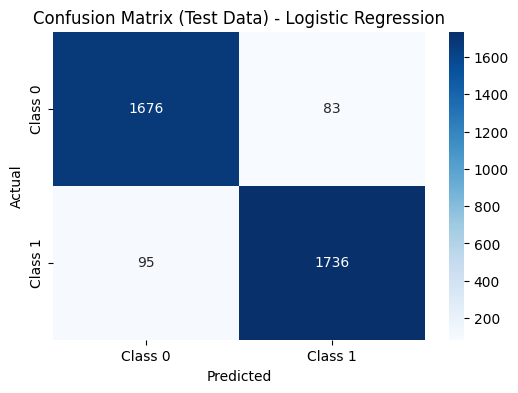

In [22]:
from sklearn.linear_model import LogisticRegression

# Train the model
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

# Predictions for test data
y_pred_test = clf.predict(X_test)

# Predictions for training data
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train,"Logistic Regression")

### Bagging

=== Test Metrics ===
Accuracy: 0.9498607242339833
Precision: 0.9528250137136588
Recall: 0.9486619333697434
F1 Score: 0.9507389162561576

=== Training Metrics ===
Accuracy: 0.948592922819727
Precision: 0.9469886205939495
Recall: 0.9504178272980501
F1 Score: 0.948700125121646

X_train shape: (14356, 23)


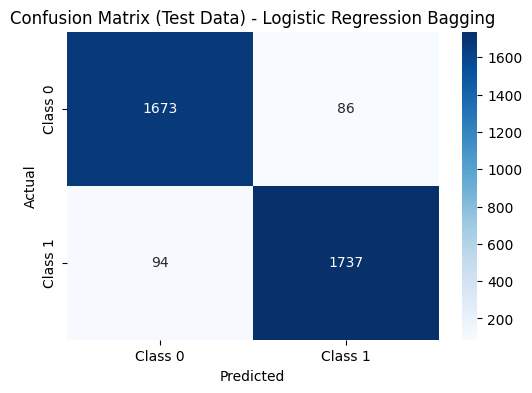

In [23]:
from sklearn.ensemble import BaggingClassifier
# Use logistic model
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=50, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"Logistic Regression Bagging")

### Boosting

=== Test Metrics ===
Accuracy: 0.9278551532033427
Precision: 0.9356984478935698
Recall: 0.9219006007646096
F1 Score: 0.928748280605227

=== Training Metrics ===
Accuracy: 0.9243521872387852
Precision: 0.9249651324965132
Recall: 0.9236768802228412
F1 Score: 0.9243205574912892

X_train shape: (14356, 23)


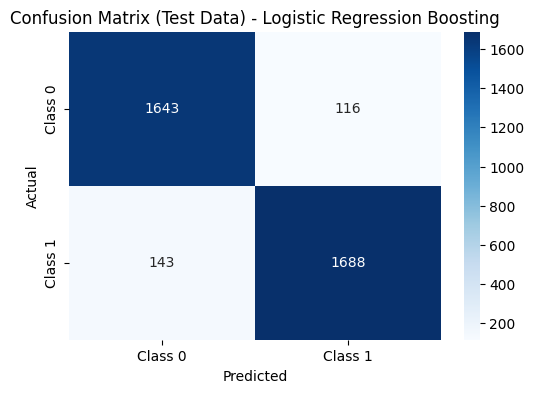

In [24]:
from sklearn.ensemble import AdaBoostClassifier
# Use logistic model 
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=100, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"Logistic Regression Boosting")

## Wrapper Method
running the RFE wrapper method recursively until the percision value begins decreasing from the elimination of Features within the dataset

In [25]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

Baseline F1: 0.9512
Starting with 23 features
Selecting 22 features from 23 current features
Removed 'p1_ht' → new F1 = 0.9512
Selecting 21 features from 22 current features
Removed 'p1_hand' → new F1 = 0.9515
Selecting 20 features from 21 current features
Removed 'p1_rank_points' → new F1 = 0.9515
Selecting 19 features from 20 current features
→ Stopping: dropping 'p2_rank' drops F1 from 0.9512 to 0.9509

Total removed: 4 features
Features removed (in order):
 - p1_ht
 - p1_hand
 - p1_rank_points
 - p2_rank


## Decision Tree

=== Test Metrics ===
Accuracy: 0.6493036211699165
Precision: 0.6164495114006515
Recall: 0.8268705625341344
F1 Score: 0.7063214369022627

=== Training Metrics ===
Accuracy: 0.6485093340763444
Precision: 0.6092566045463854
Recall: 0.8286908077994429
F1 Score: 0.7022306148943703

X_train shape: (14356, 23)


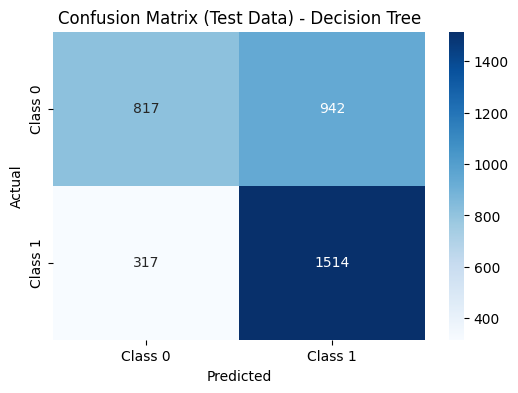

In [26]:
from sklearn.tree import DecisionTreeClassifier

# Train the model
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)
clf.fit(X_train, y_train)

# Predictions for test data
y_pred_test = clf.predict(X_test)

# Predictions for training data
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train,"Decision Tree")

### Bagging

=== Test Metrics ===
Accuracy: 0.7164345403899721
Precision: 0.6938483547925608
Recall: 0.7946477334789732
F1 Score: 0.7408350305498982

=== Training Metrics ===
Accuracy: 0.7284758985789913
Precision: 0.6983800773694391
Recall: 0.8045961002785516
F1 Score: 0.7477349210458193

X_train shape: (14356, 23)


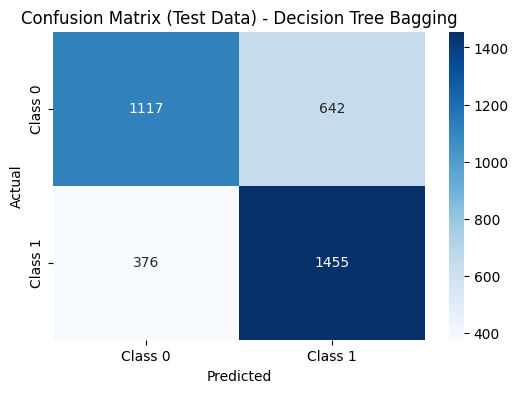

In [27]:
# Use decision tree model
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=50, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train, "Decision Tree Bagging")

### Boosting

=== Test Metrics ===
Accuracy: 0.9203342618384401
Precision: 0.9219006007646096
Recall: 0.9219006007646096
F1 Score: 0.9219006007646096

=== Training Metrics ===
Accuracy: 0.9607132906101978
Precision: 0.96421554869492
Recall: 0.9569637883008356
F1 Score: 0.9605759821054103

X_train shape: (14356, 23)


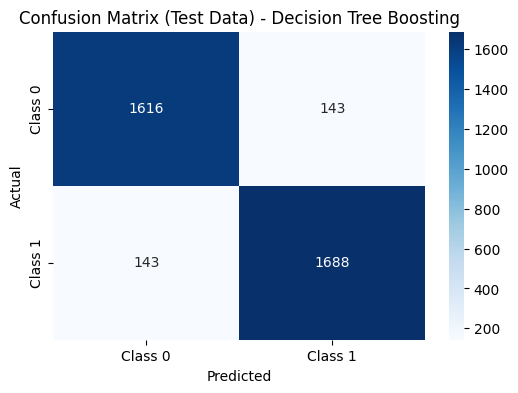

In [28]:
# Use decision tree model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=100, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train, "Decision Tree Boosting")

## Wrapper Methods

In [29]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

Baseline F1: 0.7063
Starting with 23 features
Selecting 22 features from 23 current features
Removed 'surface' → new F1 = 0.7063
Selecting 21 features from 22 current features
Removed 'p1_hand' → new F1 = 0.7063
Selecting 20 features from 21 current features
Removed 'p1_ht' → new F1 = 0.7063
Selecting 19 features from 20 current features
Removed 'p1_age' → new F1 = 0.7063
Selecting 18 features from 19 current features
Removed 'p2_hand' → new F1 = 0.7063
Selecting 17 features from 18 current features
Removed 'p2_ht' → new F1 = 0.7063
Selecting 16 features from 17 current features
Removed 'p2_age' → new F1 = 0.7063
Selecting 15 features from 16 current features
Removed 'p1_ace' → new F1 = 0.7063
Selecting 14 features from 15 current features
Removed 'p1_df' → new F1 = 0.7063
Selecting 13 features from 14 current features
Removed 'p1_1stIn' → new F1 = 0.7063
Selecting 12 features from 13 current features
Removed 'p2_ace' → new F1 = 0.7063
Selecting 11 features from 12 current features
Rem

## Random Forest

=== Test Metrics ===
Accuracy: 0.8105849582172702
Precision: 0.807261078483716
Recall: 0.8257782632441288
F1 Score: 0.816414686825054

=== Training Metrics ===
Accuracy: 0.8899414878796322
Precision: 0.87817396002161
Recall: 0.9055710306406686
F1 Score: 0.8916620954470653

X_train shape: (14356, 23)


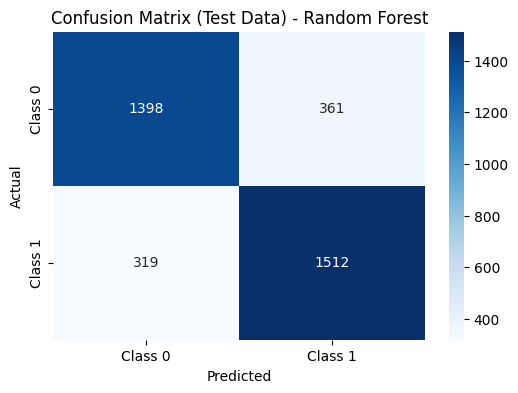

In [30]:
from sklearn.ensemble import RandomForestClassifier

# Train the model
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
clf.fit(X_train, y_train)

# Predictions
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train,"Random Forest")

### Bagging

=== Test Metrics ===
Accuracy: 0.8167130919220056
Precision: 0.8104817363684489
Recall: 0.8361551064991808
F1 Score: 0.8231182795698925

=== Training Metrics ===
Accuracy: 0.8835330175536361
Precision: 0.8700618113410373
Recall: 0.9018105849582173
F1 Score: 0.8856517576254959

X_train shape: (14356, 23)


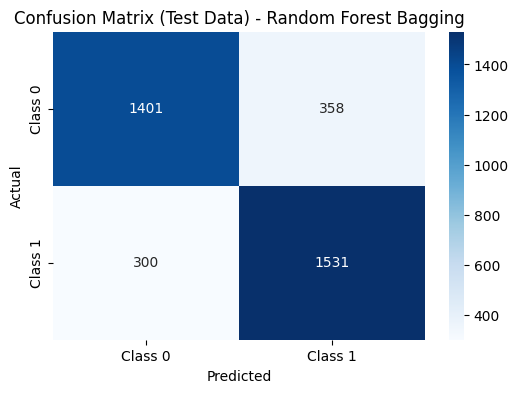

In [31]:
# Use random forest model
bagging_clf = BaggingClassifier(estimator=clf, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"Random Forest Bagging")

### Boosting

=== Test Metrics ===
Accuracy: 0.8949860724233983
Precision: 0.892548596112311
Recall: 0.902785363189514
F1 Score: 0.8976377952755905

=== Training Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

X_train shape: (14356, 23)


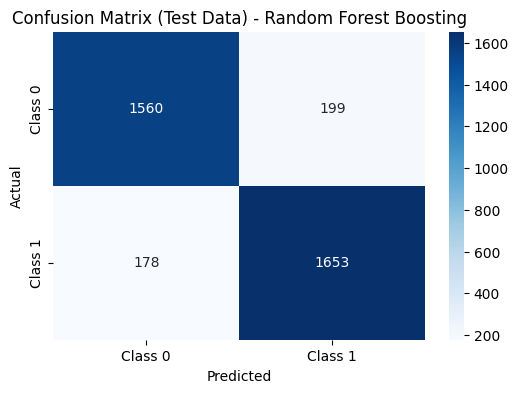

In [32]:
# Use random forest model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=15, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"Random Forest Boosting")

## Wrapper Methods

In [34]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

Baseline F1: 0.8164
Starting with 23 features
Selecting 22 features from 23 current features
Removed 'p2_hand' → new F1 = 0.8173
Selecting 21 features from 22 current features
Removed 'p1_hand' → new F1 = 0.8175
Selecting 20 features from 21 current features
Removed 'surface' → new F1 = 0.8165
Selecting 19 features from 20 current features
Removed 'p1_ht' → new F1 = 0.8233
Selecting 18 features from 19 current features
Removed 'p2_ht' → new F1 = 0.8211
Selecting 17 features from 18 current features
Removed 'p2_age' → new F1 = 0.8233
Selecting 16 features from 17 current features
Removed 'p1_age' → new F1 = 0.8301
Selecting 15 features from 16 current features
→ Stopping: dropping 'p2_df' drops F1 from 0.8164 to 0.8144

Total removed: 8 features
Features removed (in order):
 - p2_hand
 - p1_hand
 - surface
 - p1_ht
 - p2_ht
 - p2_age
 - p1_age
 - p2_df


## KNN

=== Test Metrics ===
Accuracy: 0.775766016713092
Precision: 0.778804347826087
Recall: 0.7826324412889132
F1 Score: 0.7807137019885589

=== Training Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

X_train shape: (14356, 23)


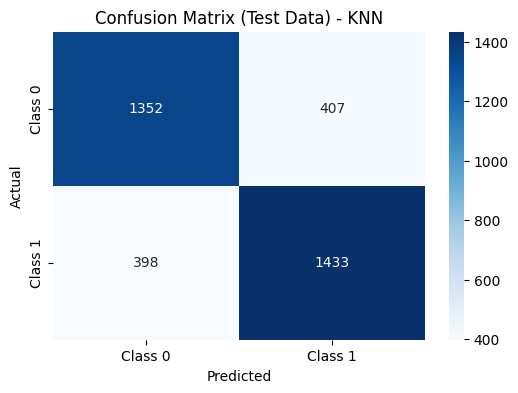

In [35]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize and fit the model
neigh = KNeighborsClassifier(n_neighbors=100, weights='distance', algorithm='auto')
neigh.fit(X_train, y_train)

# Predictions
y_pred_test = neigh.predict(X_test)
y_pred_train = neigh.predict(X_train)

evaluate_model(y_pred_test, y_pred_train,"KNN")

### Bagging

=== Test Metrics ===
Accuracy: 0.8167130919220056
Precision: 0.8104817363684489
Recall: 0.8361551064991808
F1 Score: 0.8231182795698925

=== Training Metrics ===
Accuracy: 0.8835330175536361
Precision: 0.8700618113410373
Recall: 0.9018105849582173
F1 Score: 0.8856517576254959

X_train shape: (14356, 23)


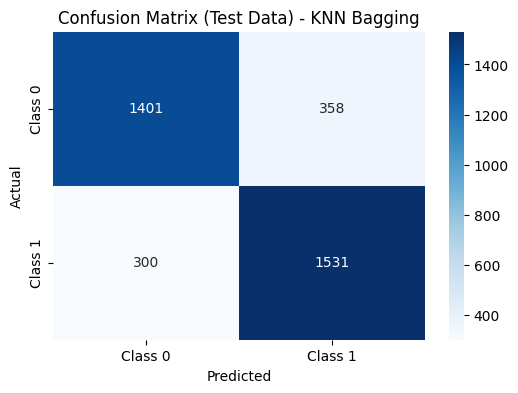

In [36]:
# Use KNN model
bagging_clf = BaggingClassifier(estimator=clf, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"KNN Bagging")

### Boosting

=== Test Metrics ===
Accuracy: 0.8949860724233983
Precision: 0.892548596112311
Recall: 0.902785363189514
F1 Score: 0.8976377952755905

=== Training Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

X_train shape: (14356, 23)


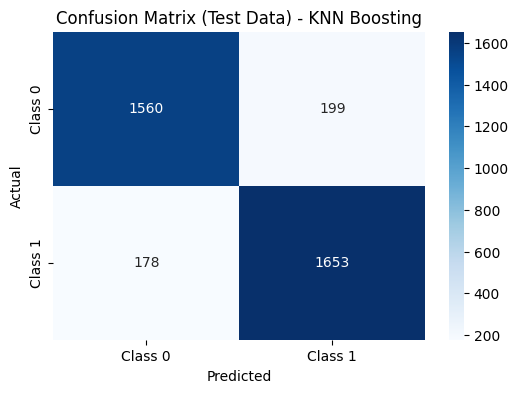

In [37]:
# Use KNN model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=15, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"KNN Boosting")

## Wrapper Method

In [38]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

Baseline F1: 0.8164
Starting with 23 features
Selecting 22 features from 23 current features
Removed 'p2_hand' → new F1 = 0.8173
Selecting 21 features from 22 current features
Removed 'p1_hand' → new F1 = 0.8175
Selecting 20 features from 21 current features
Removed 'surface' → new F1 = 0.8165
Selecting 19 features from 20 current features
Removed 'p1_ht' → new F1 = 0.8233
Selecting 18 features from 19 current features
Removed 'p2_ht' → new F1 = 0.8211
Selecting 17 features from 18 current features
Removed 'p2_age' → new F1 = 0.8233
Selecting 16 features from 17 current features
Removed 'p1_age' → new F1 = 0.8301
Selecting 15 features from 16 current features
→ Stopping: dropping 'p2_df' drops F1 from 0.8164 to 0.8144

Total removed: 8 features
Features removed (in order):
 - p2_hand
 - p1_hand
 - surface
 - p1_ht
 - p2_ht
 - p2_age
 - p1_age
 - p2_df


## SVM Linear Kernel

=== Test Metrics ===
Accuracy: 0.949025069637883
Precision: 0.9522502744237102
Recall: 0.9475696340797378
F1 Score: 0.949904188338352

=== Training Metrics ===
Accuracy: 0.9487322373920312
Precision: 0.9472515269294837
Recall: 0.9504178272980501
F1 Score: 0.9488320355951056

X_train shape: (14356, 23)


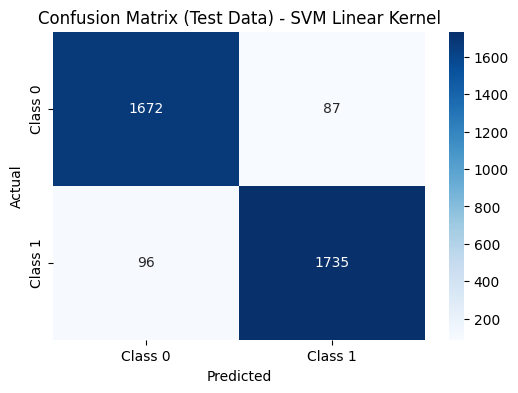

In [39]:
from sklearn.svm import LinearSVC

# Train the model
clf = LinearSVC(random_state=0, tol=1e-5, C=1.0)
clf.fit(X_train, y_train)

# Predictions
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train,"SVM Linear Kernel")

### Bagging

=== Test Metrics ===
Accuracy: 0.9498607242339833
Precision: 0.9528250137136588
Recall: 0.9486619333697434
F1 Score: 0.9507389162561576

=== Training Metrics ===
Accuracy: 0.9488018946781833
Precision: 0.9472588480222068
Recall: 0.9505571030640668
F1 Score: 0.948905109489051

X_train shape: (14356, 23)


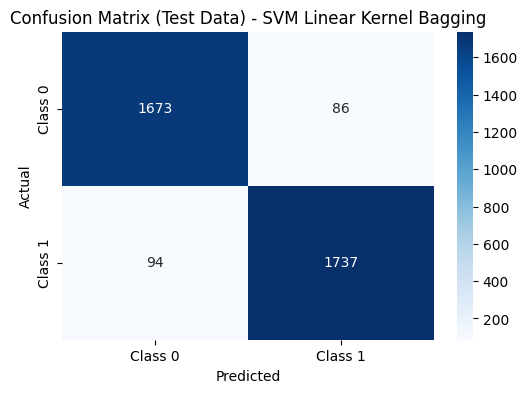

In [40]:
# Use linear SVM model
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=50, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"SVM Linear Kernel Bagging")

### Boosting

=== Test Metrics ===
Accuracy: 0.9392757660167131
Precision: 0.9424026330224904
Recall: 0.9382850901146914
F1 Score: 0.9403393541324576

=== Training Metrics ===
Accuracy: 0.9313875731401504
Precision: 0.9327930697219505
Recall: 0.9298050139275766
F1 Score: 0.931296645044291

X_train shape: (14356, 23)


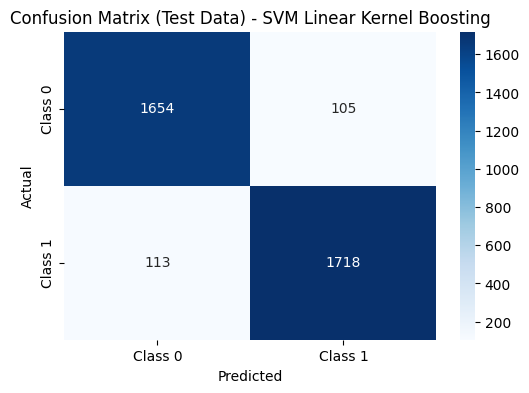

In [41]:
# Use linear SVM model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=100, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train, "SVM Linear Kernel Boosting")

## Wrapper Method

In [42]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

Baseline F1: 0.9499
Starting with 23 features
Selecting 22 features from 23 current features
Removed 'p1_hand' → new F1 = 0.9499
Selecting 21 features from 22 current features
Removed 'p1_ht' → new F1 = 0.9499
Selecting 20 features from 21 current features
Removed 'p2_age' → new F1 = 0.9499
Selecting 19 features from 20 current features
Removed 'p2_rank' → new F1 = 0.9502
Selecting 18 features from 19 current features
→ Stopping: dropping 'p1_df' drops F1 from 0.9499 to 0.9496

Total removed: 5 features
Features removed (in order):
 - p1_hand
 - p1_ht
 - p2_age
 - p2_rank
 - p1_df


## SVM Gaussian Kernel

=== Test Metrics ===
Accuracy: 0.9345403899721448
Precision: 0.9355895196506551
Recall: 0.9361004915346806
F1 Score: 0.9358449358449359

=== Training Metrics ===
Accuracy: 0.9594594594594594
Precision: 0.9573052398114776
Recall: 0.9618384401114206
F1 Score: 0.9595664860358483

X_train shape: (14356, 23)


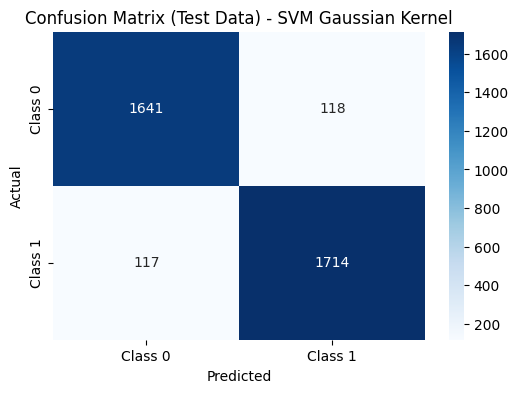

In [43]:
from sklearn.svm import SVC

# Train the model
clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=0)
clf.fit(X_train, y_train)

# Make predictions
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train, "SVM Gaussian Kernel")

### Bagging

=== Test Metrics ===
Accuracy: 0.9376044568245125
Precision: 0.9431880860452289
Recall: 0.9339158929546696
F1 Score: 0.9385290889132821

=== Training Metrics ===
Accuracy: 0.9582752855948732
Precision: 0.9589900962477333
Recall: 0.9575208913649025
F1 Score: 0.9582549306571887

X_train shape: (14356, 23)


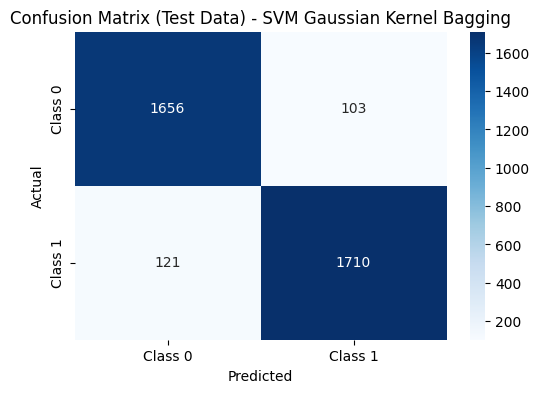

In [44]:
# Use gaussian SVM model
bagging_clf = BaggingClassifier(estimator=clf, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train, "SVM Gaussian Kernel Bagging")

# Note: Boosting results in the model predicting all 1s

## Stacking

### Decision Tree, KNN, & Random Forest -> Logistic

=== Test Metrics ===
Accuracy: 0.8233983286908078
Precision: 0.8265139116202946
Recall: 0.827416712179137
F1 Score: 0.8269650655021834

=== Training Metrics ===
Accuracy: 0.9977709668431318
Precision: 0.9977715877437325
Recall: 0.9977715877437325
F1 Score: 0.9977715877437325

X_train shape: (14356, 23)


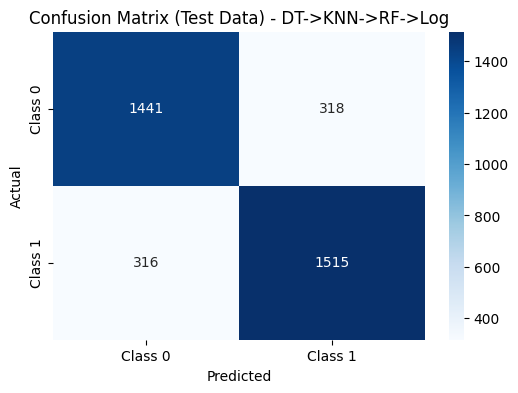

In [45]:
from sklearn.ensemble import StackingClassifier
estimators = [
  ["DecisionTreeClassifier", DecisionTreeClassifier(criterion='entropy', random_state=0)],
  ["KNeighborsClassifier", KNeighborsClassifier(n_neighbors=100, weights='distance')],
  ["RandomForestClassifier", RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)]
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=0))
# Train
stacking_clf.fit(X_train, y_train)
# Predict
y_pred_train = stacking_clf.predict(X_train)
y_pred_test = stacking_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"DT->KNN->RF->Log")

### Logistic & KNN -> Decision Tree

=== Test Metrics ===
Accuracy: 0.9267409470752089
Precision: 0.9341085271317829
Recall: 0.9213544511196068
F1 Score: 0.9276876546604345

=== Training Metrics ===
Accuracy: 0.9136249651713569
Precision: 0.9115853658536586
Recall: 0.9161559888579387
F1 Score: 0.9138649624895805

X_train shape: (14356, 23)


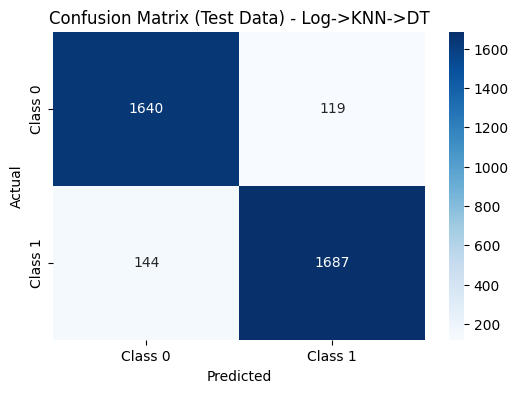

In [46]:
estimators = [
  ["LogisticRegression", LogisticRegression(random_state=0)],
  ["KNeighborsClassifier", KNeighborsClassifier(n_neighbors=100, weights='distance')]
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=DecisionTreeClassifier(random_state=0))
# Train
stacking_clf.fit(X_train, y_train)
# Predict
y_pred_train = stacking_clf.predict(X_train)
y_pred_test = stacking_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"Log->KNN->DT")

### Gaussian SVC -> Logistic

=== Test Metrics ===
Accuracy: 0.9337047353760446
Precision: 0.9378779549202859
Recall: 0.9317312943746586
F1 Score: 0.9347945205479452

=== Training Metrics ===
Accuracy: 0.9594594594594594
Precision: 0.9588317107093185
Recall: 0.96016713091922
F1 Score: 0.9594989561586639

X_train shape: (14356, 23)


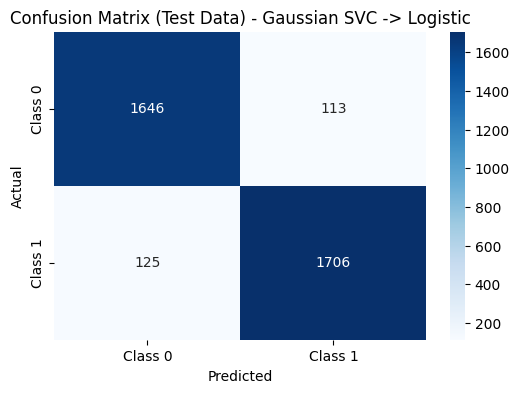

In [47]:
estimators = [
  ["SVC", SVC(kernel='rbf', C=1.0, gamma='scale', random_state=0)],
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=0))
# Train
stacking_clf.fit(X_train, y_train)
# Predict
y_pred_train = stacking_clf.predict(X_train)
y_pred_test = stacking_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train, "Gaussian SVC -> Logistic")

In [49]:
def plot_model_results(results_df):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
    melted_df = pd.melt(
        results_df,
        id_vars=['Model'],
        value_vars=[f'Train {m}' for m in metrics] + [f'Test {m}' for m in metrics],
        var_name='Metric Type',
        value_name='Score'
    )

    # Split Metric Type into two columns: Data Split and Metric
    melted_df[['Split', 'Metric']] = melted_df['Metric Type'].str.extract(r'(Train|Test)\s+(.*)')

    # Plot
    g = sns.catplot(
        data=melted_df,
        kind='bar',
        x='Model',
        y='Score',
        hue='Split',
        col='Metric',
        col_wrap=2,
        height=4,
        aspect=1.2,
        palette='Set2',
        sharey=False
    )
    g.set_titles("{col_name}")
    g.set_axis_labels("Model", "Score")
    g.set_xticklabels(rotation=45)
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle("Training vs Test Metrics by Model")
    plt.show()

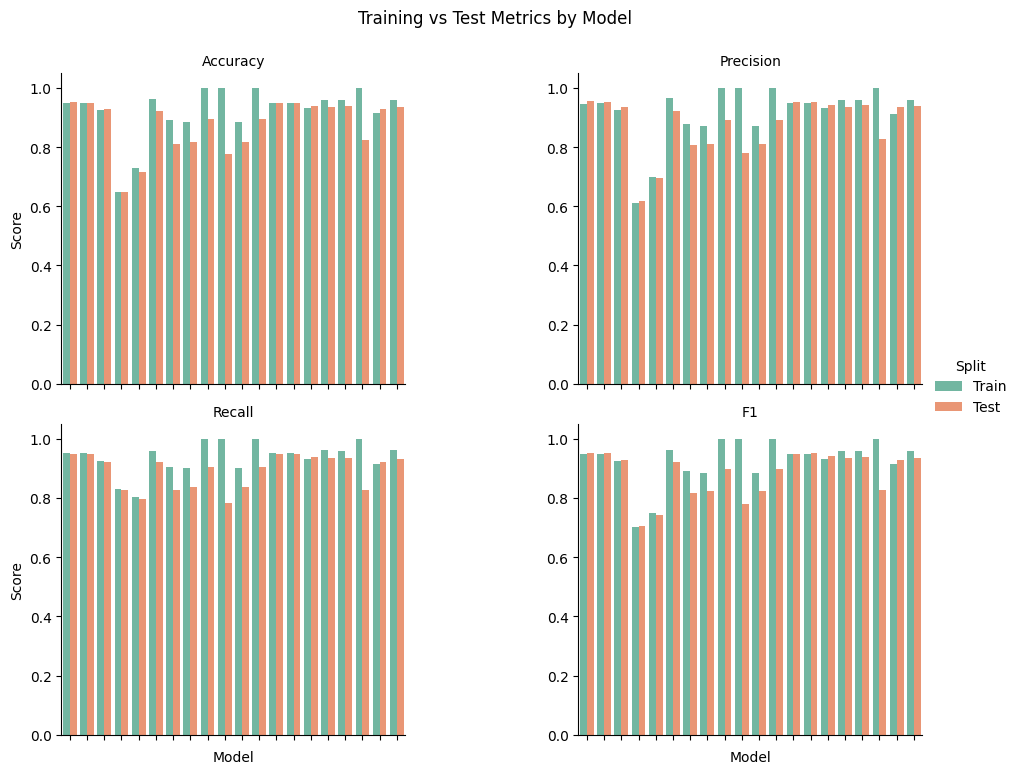

In [50]:
plot_model_results(pd.DataFrame(model_results))

## KNN With HyperTuning

In [51]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import GridSearchCV
# import pandas as pd

# param_grid = {
#     "n_neighbors": [100, 200],
#     "weights":     ["uniform", "distance"],
#     "metric":      ["euclidean", "manhattan"],
#     "algorithm":   ["auto", "kd_tree", "ball_tree"]
# }

# grid_knn = GridSearchCV(
#     estimator   = KNeighborsClassifier(),
#     param_grid  = param_grid,
#     scoring     = "balanced_accuracy",
#     verbose     = 0
# )

# grid_knn.fit(X_train, y_train)

# print("Best hyper‑parameters:", grid_knn.best_params_)
# print(f"Best score (train only): {grid_knn.best_score_:.4f}")

# best_knn      = grid_knn.best_estimator_
# y_pred_test   = best_knn.predict(X_test)
# y_pred_train  = best_knn.predict(X_train)

# # Custom evaluation
# evaluate_model(y_pred_test, y_pred_train)

# results = pd.DataFrame(grid_knn.cv_results_)
# top5 = results.sort_values(by="mean_test_score", ascending=False).head()

# print("Top 5 configs:")
# print(top5[["params", "mean_test_score"]])

## DecisionTreeClassifier with Hypertuning

=== Test Metrics ===
Accuracy: 0.7610027855153203
Precision: 0.7787965616045845
Recall: 0.742217367558711
F1 Score: 0.7600671140939598

=== Training Metrics ===
Accuracy: 0.805586514349401
Precision: 0.811409110259685
Recall: 0.7963788300835655
F1 Score: 0.8038237154705841

X_train shape: (14356, 23)


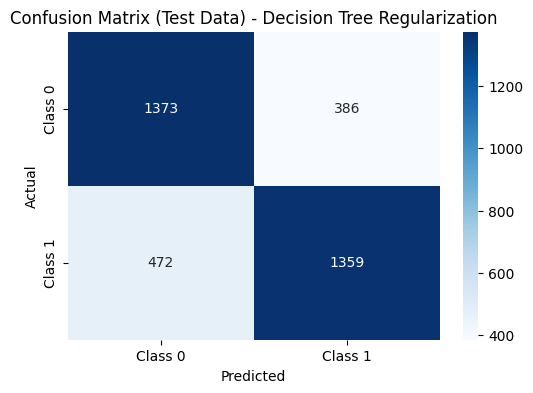

In [52]:
from sklearn.tree import DecisionTreeClassifier

dt_manual = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42
)
dt_manual.fit(X_train, y_train)

y_pred_test  = dt_manual.predict(X_test)
y_pred_train = dt_manual.predict(X_train)

evaluate_model(y_pred_test, y_pred_train,"Decision Tree Regularization")

## Logistic Regression With Hypertuning

=== Test Metrics ===
Accuracy: 0.9501392757660168
Precision: 0.9543454345434543
Recall: 0.9475696340797378
F1 Score: 0.9509454645108248

=== Training Metrics ===
Accuracy: 0.9483839509612706
Precision: 0.9472148909570773
Recall: 0.9497214484679666
F1 Score: 0.9484665136657626

X_train shape: (14356, 23)


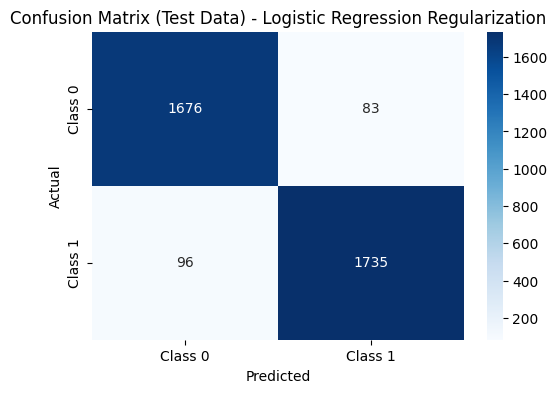

In [54]:
# Tried on this one but not much change, running gridsearch on all will blow up our computers

# testing elastic 
from sklearn.linear_model import LogisticRegression

log_manual = LogisticRegression(
    penalty="elasticnet",
    C=1.0,
    l1_ratio=0.5,
    class_weight="balanced",
    solver="saga",
    max_iter=10000,
    random_state=42
)
log_manual.fit(X_train, y_train)

y_pred_test  = log_manual.predict(X_test)
y_pred_train = log_manual.predict(X_train)

evaluate_model(y_pred_test, y_pred_train,"Logistic Regression Regularization")

In [55]:
pd.DataFrame(model_results)

,Model,Train Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
0,Logistic Regression,0.948384,0.946967,0.950000,0.948481,0.950418,0.954371,0.948116,0.951233
1,Logistic Regression Bagging,0.948593,0.946989,0.950418,0.948700,0.949861,0.952825,0.948662,0.950739
2,Logistic Regression Boosting,0.924352,0.924965,0.923677,0.924321,0.927855,0.935698,0.921901,0.928748
3,Decision Tree,0.648509,0.609257,0.828691,0.702231,0.649304,0.616450,0.826871,0.706321
4,Decision Tree Bagging,0.728476,0.698380,0.804596,0.747735,0.716435,0.693848,0.794648,0.740835
5,Decision Tree Boosting,0.960713,0.964216,0.956964,0.960576,0.920334,0.921901,0.921901,0.921901
6,Random Forest,0.889941,0.878174,0.905571,0.891662,0.810585,0.807261,0.825778,0.816415
7,Random Forest Bagging,0.883533,0.870062,0.901811,0.885652,0.816713,0.810482,0.836155,0.823118
8,Random Forest Boosting,1.000000,1.000000,1.000000,1.000000,0.894986,0.892549,0.902785,0.897638
9,KNN,1.000000,1.000000,1.000000,1.000000,0.775766,0.778804,0.782632,0.780714
